# Search and Classify 

## Import Classifier 

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.externals import joblib
import cv2
from scipy.ndimage.measurements import label

dist_pickle = joblib.load("classifier.p")
model = dist_pickle["model"]
color_space = dist_pickle['config']["color_space"]
orient = dist_pickle['config']["orient"]
pix_per_cell = dist_pickle['config']["pix_per_cell"]
cell_per_block = dist_pickle['config']["cell_per_block"]
spatial_size = dist_pickle['config']["spatial_size"]
hist_bins = dist_pickle['config']["hist_bins"]
hog_channel = dist_pickle['config']['hog_channel']
spatial_feat = dist_pickle['config']['spatial_feat']
hist_feat = dist_pickle['config']['hist_feat']
hog_feat = dist_pickle['config']['hog_feat']

output_path = "./output_images"
global previous_heatmap

## Lesson Functions and Finding Car Functions   

In [23]:
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    file_features = []

    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Detection helper functions
def draw_boxes(img, bboxes, color, thick):
    imcopy = np.copy(img)

    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy


def slide_window(img, x_start_stop, y_start_stop, xy_window, xy_overlap):
    # If x and/or y start/stop positions not defined, set them to the image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0

    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]

    if y_start_stop[0] == None:
        y_start_stop[0] = 0

    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1

    # Initialize a list to append window positions to
    window_list = []

    # Append window position to list
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

    # Return the list of windows
    return window_list


def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    new_heatmap = np.copy(heatmap)
    new_heatmap[new_heatmap <= threshold] = 0

    return new_heatmap


def draw_labeled_bboxes(image, labels):
    # Iterate through all detected vehicles
    for vehicle_id in range(1, labels[1] + 1):
        # Find pixels with each vehicle_id label value
        nonzero = (labels[0] == vehicle_id).nonzero()

        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], (0, 0, 255), 6)

    # Return the image
    return image


def search_windows(img, windows):
    on_windows = []

    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from the original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        test_features = extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)        

        # Predict using the classifier
        prediction = model.predict(test_features)

        # If prediction is 1 (= vehicle) then save the window
        if prediction == 1:
            on_windows.append(window)

    # Return windows for positive detections
    return on_windows

def find_car(frame, 
             verbose=False, 
             new_image=False, 
             heat_smooth_factor = 0.2,    # smoothing factor for heatmaps of the current and previous frame
             heat_single_frame_threshold = 4, # threshold for the heatmap of a single frame
             heat_multi_frame_threshold = 4): # threshold for the heatmap of a number of frames combined
    
        global previous_heatmap
        if new_image:
            previous_heatmap = None
            
        all_windows = []

        # Grid 1 (closest to the horizon)
        win_size = 60
        y_start = int(frame.shape[0] / 2) + 20
        y_stop = y_start + win_size / 0.75
        x_start = 480
        x_stop = None
        windows_small = slide_window(frame, 
                                     x_start_stop=[x_start, x_stop], 
                                     y_start_stop=[y_start, y_stop],
                                     xy_window=(win_size, win_size), 
                                     xy_overlap=(0.75, 0.75))
        all_windows += windows_small

        if verbose:
            window_img = draw_boxes(frame, windows_small, color=(0, 0, 255), thick=2)

        # Grid 2
        win_size = 80
        y_start = int(frame.shape[0] / 2) + 40
        y_stop = y_start + win_size / 0.75
        x_start = 400
        x_stop = None
        windows_med = slide_window(frame,
                                   x_start_stop=[x_start, x_stop], 
                                   y_start_stop=[y_start, y_stop],
                                   xy_window=(win_size, win_size), 
                                   xy_overlap=(0.75, 0.75))
        all_windows += windows_med

        if verbose:
            window_img = draw_boxes(window_img, windows_med, color=(0, 255, 0), thick=2)

        # Grid 3
        win_size = 120
        y_start = int(frame.shape[0] / 2) + 60
        y_stop = y_start + win_size / 0.75
        x_start = 380
        x_stop = None
        windows_bot = slide_window(frame, 
                                   x_start_stop=[x_start, x_stop], 
                                   y_start_stop=[y_start, y_stop],
                                   xy_window=(win_size, win_size), 
                                   xy_overlap=(0.75, 0.75))

        all_windows += windows_bot
        
        if verbose:
            window_img = draw_boxes(window_img, windows_bot, color=(255, 0, 0), thick=2)

        # Grid 4 (closest to the camera car)
        win_size = 160
        y_start = int(frame.shape[0] / 2) + 80
        y_stop = y_start + win_size / 0.75 - 60
        x_start = 340
        x_stop = None
        windows_bot = slide_window(frame, 
                                   x_start_stop=[x_start, x_stop], 
                                   y_start_stop=[y_start, y_stop],
                                   xy_window=(win_size, win_size), 
                                   xy_overlap=(0.75, 0.75))

        all_windows += windows_bot
        
        if verbose:
            window_img = draw_boxes(window_img, windows_bot, color=(255, 255, 0), thick=2)


        if verbose:
            print('Number of sliding windows used: {}'.format(len(all_windows)))

        # 2. Extract features for each sliding window and predict whther it contains a vehicle using the classifier
        hot_windows = search_windows(frame, all_windows)
        
        if verbose:
            print('Number of windows that contain a detected vehicle: {}'.format(len(hot_windows)))

        # Draw all windows that contain a detected vehicle (may include overlaps and false positives)
        if verbose:
            window_det = draw_boxes(frame, hot_windows, color=(255, 255, 255), thick=6)
            plt.figure(figsize=(12, 8)) 
            plt.imshow(window_det)
            plt.show()
            image_tmp = cv2.resize(window_det, (int(window_det.shape[1] / 2), int(window_det.shape[0] / 2)))
            plt.imsave(output_path + '/all_detections.jpg', image_tmp)

        # 3. Combine duplicate detections by creating a heatmap
        current_heatmap = np.zeros_like(frame[:, :, 0]).astype(np.float)
        current_heatmap = add_heat(current_heatmap, hot_windows)

        # Show heatmap prior to thresholding
        if verbose:
            plt.figure(figsize=(12, 8))
            plt.imshow(current_heatmap, cmap='hot')
            plt.show()
            image_tmp = cv2.resize(current_heatmap, (int(current_heatmap.shape[1] / 2), int(current_heatmap.shape[0] /
                                                                                          2)))
            plt.imsave(output_path + '/heatmap_prior_thresholding.jpg', image_tmp)

        # 4. Threshold the heatmap to remove false positives and duplicate detections
        current_heatmap_thresh = apply_threshold(current_heatmap, heat_single_frame_threshold)

        # Show heatmap prior to smoothing
        if verbose:
            plt.figure(figsize=(12, 8))
            plt.imshow(current_heatmap_thresh, cmap='hot')
            plt.show()
            image_tmp = cv2.resize(current_heatmap_thresh, (int(current_heatmap_thresh.shape[1] / 2),
                                                            int(current_heatmap_thresh.shape[0] / 2)))
            plt.imsave(output_path + '/heatmap_post_thresholding.jpg', image_tmp)

        # 5. Determine the number of vehicles and their position by identifying the positions and regions in the heatmap
        if previous_heatmap is None:
            # There is no previous frame heat map so just use blank images
            
            labels = label(current_heatmap_thresh)
            previous_heatmap = current_heatmap_thresh
        else:
            
            # Use a smoothing factor to combine the current and previous frame heat map
            current_heatmap_combined = previous_heatmap * heat_smooth_factor + current_heatmap_thresh * (1 - heat_smooth_factor)

            # Apply a different threshold to the combined heatmap
            current_heatmap_combined_thresh = apply_threshold(current_heatmap_combined, heat_multi_frame_threshold)

            labels = label(current_heatmap_combined_thresh)
            previous_heatmap = current_heatmap_combined_thresh

        # 6. Draw the bounding boxes of the detected regions in the original image/frame
        window_hot = draw_labeled_bboxes(np.copy(frame), labels)

        # Show detected car blobs
        if verbose:
            plt.figure(figsize=(12, 8))
            plt.imshow(labels[0], cmap='gray')
            plt.show()
            plt.imsave(output_path + '/labeled_regions.jpg', labels[0])

        if verbose:
            return window_img, all_windows, window_hot, hot_windows
        else:
            return window_hot

In [24]:
def process_image_verbose(file_name, vehicle_classifier):
    '''Detect vehicles in a single test image, show images of subsequent pipeline steps'''

    image = mpimg.imread(file_name)

    # Perform vehicle detection
    image_windows, sliding_windows, image_det, detected_windows = find_car(image, verbose=True, new_image=True)

    # Plot and show the resulting image (for the README.md)
    if image_windows is not None:
        plt.figure(figsize=(12,8))
        plt.imshow(image_windows)
        plt.title('sliding windows')
        plt.show()

        # Save a copy of the result reduced to 25% of the original size
        image_windows = cv2.resize(image_windows, (int(image_windows.shape[1]/2), int(image_windows.shape[0]/2)))
        plt.imsave(output_path + "/test_sliding_windows_grid.jpg", image_windows)

    # Plot and show the resulting image (for the README.md)
    if image_det is not None:
        plt.figure(figsize=(12,8))
        plt.imshow(image_det)
        plt.title('hot window')
        plt.show()

        # Save a copy of the result reduced to 25% of the original size
        image_det = cv2.resize(image_det, (int(image_det.shape[1]/2), int(image_det.shape[0]/2)))
        plt.imsave(output_path + "/test_hot_windows.jpg", image_det)


def process_images(dir_name, vehicle_classifier):
    '''Detect vehicles in all six test images'''

    images = []
    for i in range(0, 6):
        images.append(mpimg.imread(dir_name + '/test{}.jpg'.format(i+1)))

    # Plot the original image next to the image showing the detected vehicles
    fig, axis = plt.subplots(len(images), 2)
    for row in range(len(images)):
        image_org = images[row]
        axis[row, 0].imshow(image_org)
        axis[row, 0].axis('off')

        # Detect the vehicles
        image_det = find_car(image_org, verbose=False, new_image=True)

        axis[row, 1].imshow(image_det)
        axis[row, 1].axis('off')
        image_tmp = cv2.resize(image_det, (int(image_det.shape[1] / 2), int(image_det.shape[0] / 2)))
        plt.imsave(output_path + '/test{}_detected.jpg'.format(row+1), image_tmp)

    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()          # Manually save the image to disk for use in the README.md


def process_video(input_video_name, output_video_name, vehicle_classifier):
    '''Detect vehicles in an entire video and write the result to disc'''

    video_input = VideoFileClip(input_video_name)
    output = video_input.fl_image(find_car)
    output.write_videofile(output_video_name, audio=False)

## Process Single Images 

Number of sliding windows used: 540


C:\Users\gtesei\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of windows that contain a detected vehicle: 44


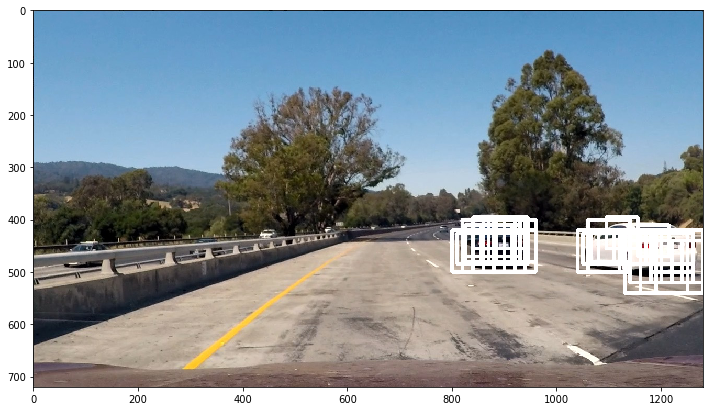

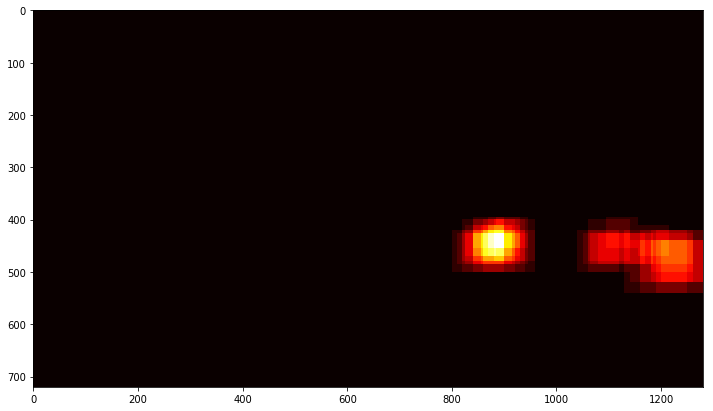

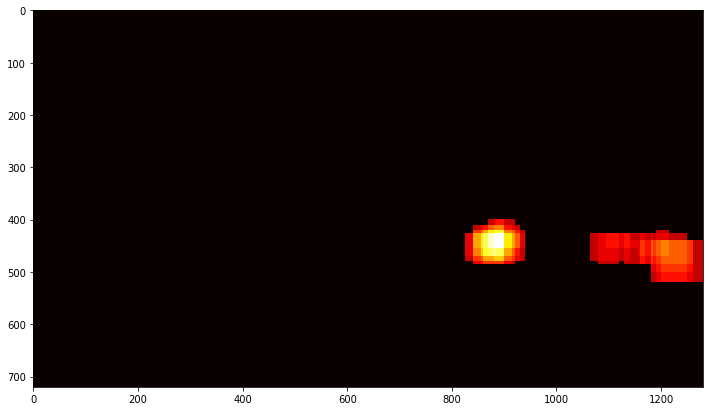

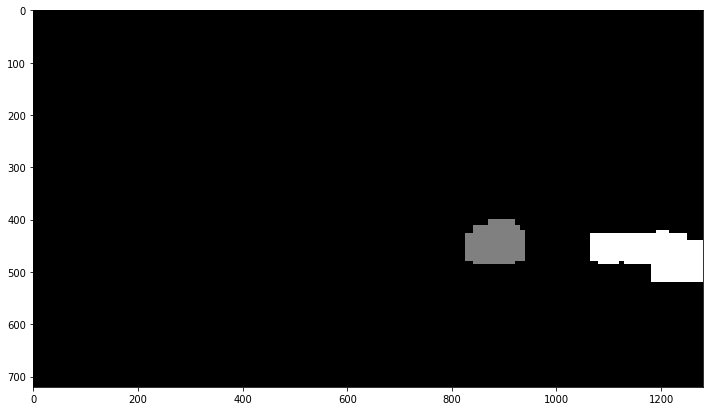

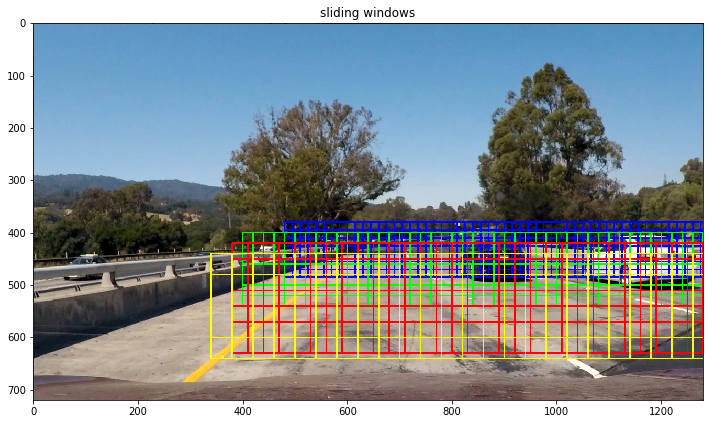

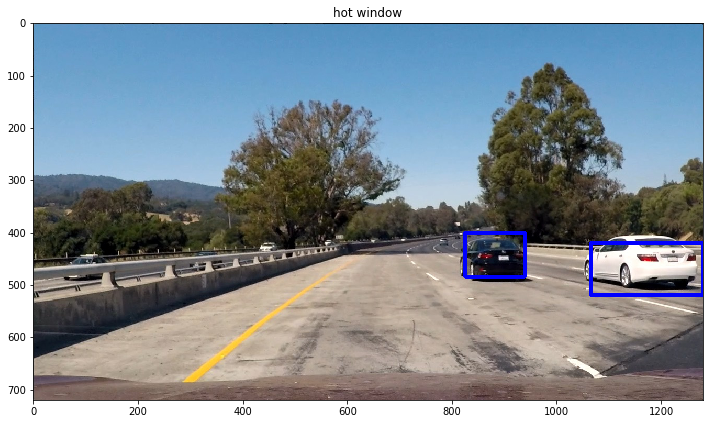

In [25]:
# Process a single test image using the trained classifier
previous_heatmap = None
process_image_verbose("./test_images/test1.jpg", model)

Number of sliding windows used: 540


C:\Users\gtesei\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of windows that contain a detected vehicle: 44


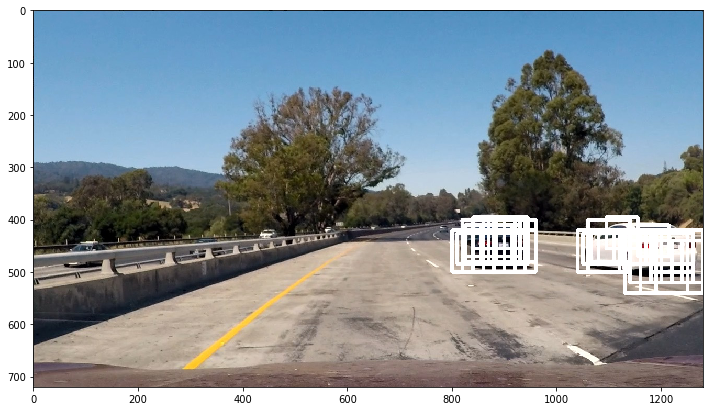

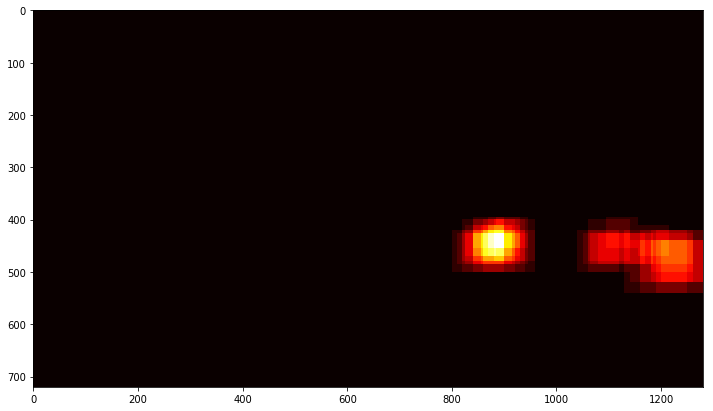

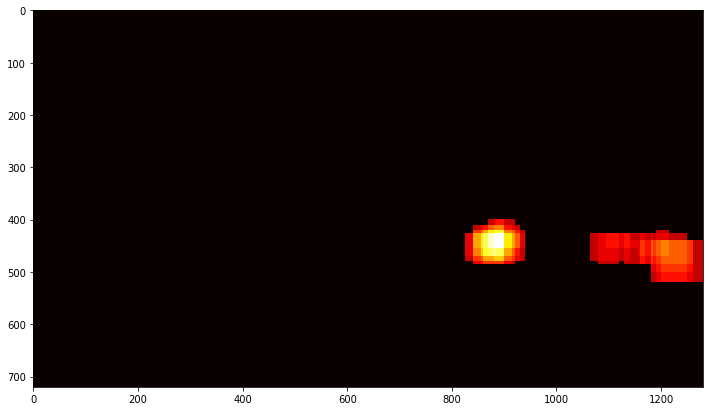

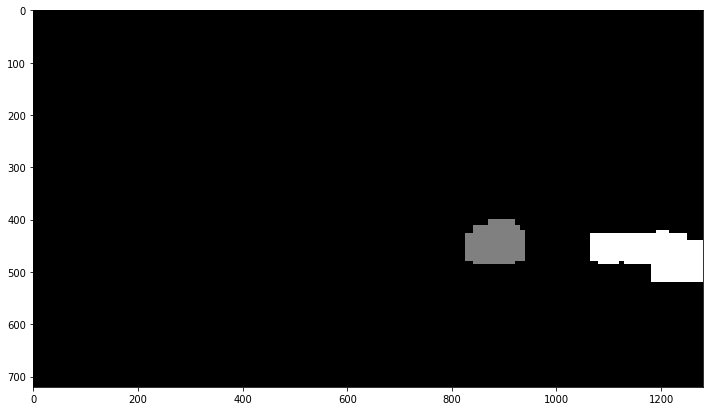

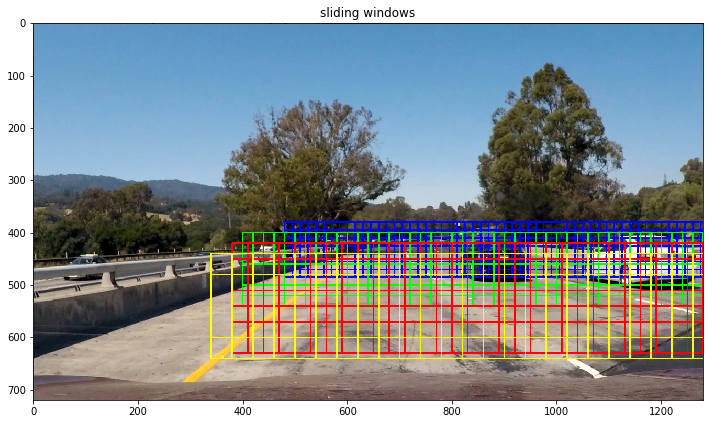

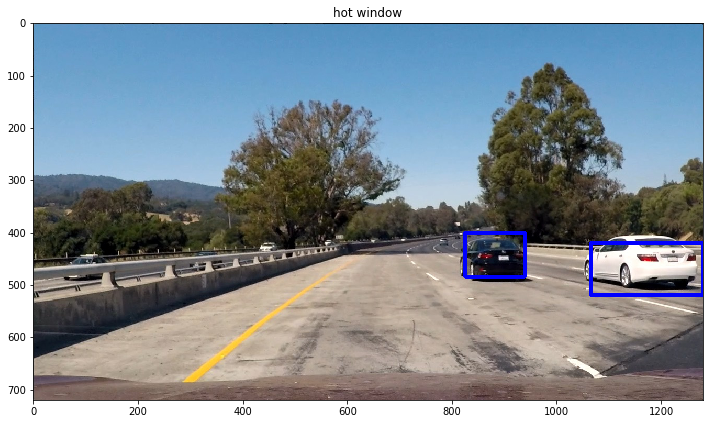

In [26]:
# Process a single test image using the trained classifier
process_image_verbose("./test_images/test1.jpg", model)

C:\Users\gtesei\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


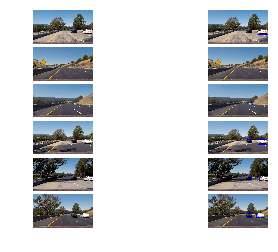

In [27]:
# Process all six test image using the trained classifier
previous_heatmap = None
process_images("./test_images", model)

## Process Test Video

In [28]:
from moviepy.editor import VideoFileClip
# Process the video using the trained classifier
previous_heatmap = None
process_video("./test_video.mp4", "./test_video_output.mp4", model)

[MoviePy] >>>> Building video ./test_video_output.mp4
[MoviePy] Writing video ./test_video_output.mp4


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 38/39 [01:24<00:02,  2.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output.mp4 



# Process Final Video  

In [29]:
from moviepy.editor import VideoFileClip
# Process the video using the trained classifier
previous_heatmap = None
process_video("./project_video.mp4", "./project_video_output_V5.mp4", model)

[MoviePy] >>>> Building video ./project_video_output_V5.mp4
[MoviePy] Writing video ./project_video_output_V5.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [43:49<00:02,  2.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output_V5.mp4 

